# Project Problem formulation



In this project, 
 - I want to create a Segmentation with customers who behave the same.

 - I want to investigate what are the common traits / behaviours in each Segment / Cluster

 - I want to deploy our results in Power BI for the business to use

 - I want to automate all this process for future data

# Import the packages and libraries to be used

In [2]:
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

from sklearn.cluster import KMeans, k_means

%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#  Loading the Raw Data into Python
    Data is obtained from open sources for several use-case projects. 

In [3]:
# Loading the data
raw_data = pd.read_csv('B2B.csv')

# print the shape
print(raw_data.shape)

#runs the first 5 rows so that we can see what kind of data we are working with
raw_data.head()

(50000, 9)


,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store
3,2497066,12,5,11/16/2018 15:58,232.99,1/2page,Stuttgart,reffered,luxury_item
4,2542664,5,7,12/6/2018 12:26,232.99,1/2page,Böblingen,campaigns,Resturant


# Dataset breakdown
We have a set of 50,000 clients. The dataset a a sample of data representing historical data of businesses that has purchase adverting product from  STM marketing and adverting company. Details of the column are explained below.
- clientID > Unique identifier for each client.
- Years > The number of years the client had been in business.
- Intervals > Number of times the client had purchase an adverting slot.
- Purchase_date > transaction date.
- Prices > product price.
- Address > The client business address.
- Acquisition > This is how STM acquired the client (User acquisition channel).
- BusinessTYPE > The busniess category of the client.



# Data Preprocessing
##  Exploratory Data Analysis & Data Cleaning

In [4]:
# Checking for null values

raw_data.isnull().sum()

Client_ID        0
Years            0
intervals        0
purchase_date    0
prices           0
products         0
Address          0
Acquisition      0
businessTYPE     0
dtype: int64

In [4]:
# There is no null value in this dataset

In [5]:
# Investigate all the elements within each column 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Client_ID :50000
The number of values for feature Years :31
The number of values for feature intervals :16
The number of values for feature purchase_date :13325
The number of values for feature prices :4 -- [144.990000 232.990000 353.990000 483.990000]
The number of values for feature products :4 -- ['1/2page' '1/4page' '3/4page' 'fullpage']
The number of values for feature Address :5 -- ['Backnang' 'Böblingen' 'Esslingen' 'Leonberg' 'Stuttgart']
The number of values for feature Acquisition :3 -- ['Events' 'campaigns' 'reffered']
The number of values for feature businessTYPE :9 -- ['Adult_Education' 'Art_Gallery' 'Boat_Tours' 'Book_Store' 'Furniture'
 'Hotel' 'Photography' 'Resturant' 'luxury_item']


From this investigation, i can make sense more precisely the unique value of the columns. 
- I now know for instance that our clients are located in 5 distint region in Baden-Württemberg, Germany. 
- I also see this data contain 3 type of Acquisition method.
- There are 4 unique propuct and associated price for them.
- Finally, our clients business are in 9 categories.

## Feature Engineering - Creating a Revenue metric,'Year' group and revenue category

I identified a need to generate the revenue for each client. The metric will be helpful both in the visualization of our data set and also an additional features for our segmentment. To generate this,  reveune per client = prices X intervals.

In [6]:
# Creating Revenue per clients.

raw_data['Revenue'] = (raw_data.prices*raw_data.intervals)

In [7]:
#checking for revenue
raw_data.head(3)

,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE,Revenue
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item,483.99
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel,353.99
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store,698.97


I would like to group the 'Years' in business into 4. This will help filter the noisy in the model i want to build for the segmentation(clustering). Aslo for visualization, i will do same for the revenue.

#### Define a function to split ' Years' into groups 

In [8]:
#First let me check for the min and max in the of number of year in business.
print(raw_data.Years.min())
print(raw_data.Years.max())

1
31


In [9]:
def yeargroup(n):
    if n < 7:
        return '0-6years'
    elif n >= 7 and n<15:
        return '7-14years'
    elif n >= 15 and n<23:
        return '15-22years'
    else:
        return 'above23years'

In [10]:
#Applying my function
raw_data['Yeargroup'] = raw_data.Years.apply(yeargroup).values

In [11]:
#checking for the new feature
raw_data.head(3)

,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE,Revenue,Yeargroup
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item,483.99,above23years
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel,353.99,7-14years
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store,698.97,above23years


#### Define a function to split ' revenue' into groups 

In [12]:
#First let me check for the min and max in the of number of year in business.
print(raw_data.Revenue.min())
print(raw_data.Revenue.max())

144.99
2319.84


In [13]:
def Revenuegrop(n):
    if n < 500:
        return 'low'
    elif n >= 500 and n<1000:
        return 'medium'
    elif n >= 1000 and n<1500:
        return 'high'
    else:
        return 'premium'

In [14]:
#Applying my function
raw_data['Revenue_Value'] = raw_data.Revenue.apply(Revenuegrop).values

In [15]:
#checking for the new feature
raw_data.head(3)

,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE,Revenue,Yeargroup,Revenue_Value
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item,483.99,above23years,low
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel,353.99,7-14years,low
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store,698.97,above23years,medium


##  Some basics Visualization

I will show a selected relationship amongst the categorical variables. so a count plot will be adequate. 

In [16]:

# Getting the columns we need

raw_data.columns

Index(['Client_ID', 'Years', 'intervals', 'purchase_date', 'prices',
       'products', 'Address', 'Acquisition', 'businessTYPE', 'Revenue',
       'Yeargroup', 'Revenue_Value'],
      dtype='object')

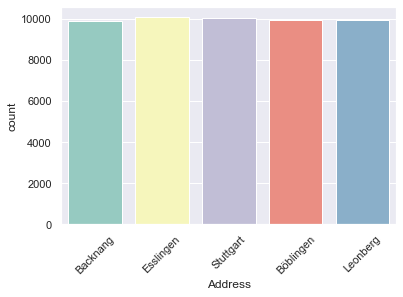

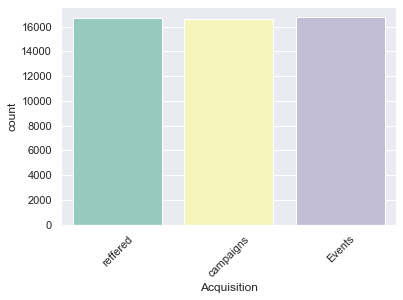

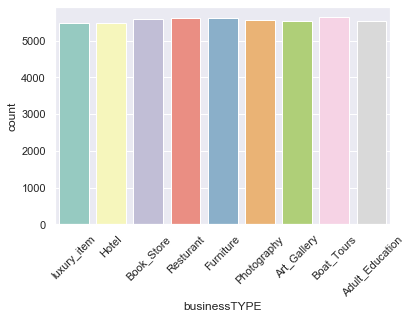

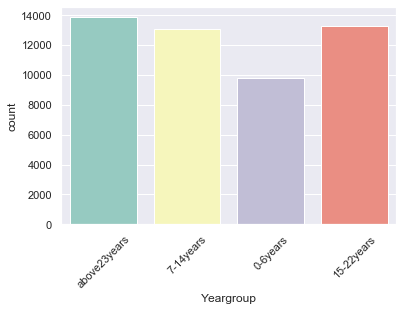

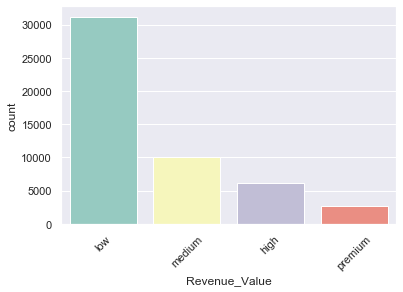

In [17]:
# Looping through all selected features  by our y variable - see the relationship
Visual_columns = ['Address', 'Acquisition', 'businessTYPE',
       'Yeargroup', 'Revenue_Value']
for v in Visual_columns:
    sns.countplot(x = v, data = raw_data, palette = 'Set3')
    plt.xticks(rotation=45)
    plt.show()

## Feature Engineering - selected Categorical variable -Test 1

In [18]:
# Making categorical variables into numeric representation

#For this i am going to take out some features that not needed(or those i modified. this is to creat a good clean model)

feature = ['products','Address','Acquisition','businessTYPE','Yeargroup','Revenue_Value']

# keeping the columns we need - Drop the other columns for now, as we do not want them to impact our results (for now)
newraw_data = raw_data[feature]
#print(raw_data.shape)

# Making categorical variables into numeric representation
new_raw_data = pd.get_dummies(newraw_data, columns = feature)

# Notes:
# We can also do this with Label Encoding and OneHotEncoder from the preprocessing library

print(new_raw_data.shape)
# print the shape

new_raw_data.head()

(50000, 29)


,products_1/2page,products_1/4page,products_3/4page,products_fullpage,Address_Backnang,Address_Böblingen,Address_Esslingen,Address_Leonberg,Address_Stuttgart,Acquisition_Events,...,businessTYPE_Resturant,businessTYPE_luxury_item,Yeargroup_0-6years,Yeargroup_15-22years,Yeargroup_7-14years,Yeargroup_above23years,Revenue_Value_high,Revenue_Value_low,Revenue_Value_medium,Revenue_Value_premium
0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,1,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [19]:
raw_data.head(3)

,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE,Revenue,Yeargroup,Revenue_Value
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item,483.99,above23years,low
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel,353.99,7-14years,low
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store,698.97,above23years,medium


### Kmeans for this set of data Test 1.

In [20]:
# Running Kmeans

X_train = new_raw_data.values

# We wills start with 5 clusters

kmeans = KMeans(n_clusters=5, random_state=540)
kmeans = kmeans.fit(X_train)

# Prints the clusters it assigned to each observation
print("The clusters are: ", kmeans.labels_)

# Prints the Inertia
print("The Inertia is: ", kmeans.inertia_)

The clusters are:  [0 1 4 ... 2 4 2]
The Inertia is:  171670.25452522884


Now i optimize the number of cluster my  model. and using the Inertia to evaluate how good our clusters are.

I give a brief explaination of INERTIA.

#### What is Inertia:
Inertia is the within-cluster sum of squares criterion. It is a metric that shows how internally coherent the clusters are. 

In [21]:
# How to find the best number of clusters?

# Running K means with multible cluster(20 here)

no_of_clusters = range(2,20) #[2,3,4,5,6,7,8,9-19]
inertia = []


for i in no_of_clusters:
    kmeans = KMeans(n_clusters=i, random_state=2)
    kmeans = kmeans.fit(X_train)
    g = kmeans.inertia_
    inertia.append(g)
    print("The inertia for :", i, "Clusters is:", g)

The inertia for : 2 Clusters is: 198817.94521438726
The inertia for : 3 Clusters is: 184338.31243342537
The inertia for : 4 Clusters is: 177363.01225627714
The inertia for : 5 Clusters is: 170017.66484786922
The inertia for : 6 Clusters is: 166382.6051983432
The inertia for : 7 Clusters is: 160961.9168103779
The inertia for : 8 Clusters is: 158246.5721753466
The inertia for : 9 Clusters is: 154823.43547653183
The inertia for : 10 Clusters is: 151944.95234036082
The inertia for : 11 Clusters is: 151095.04395140763
The inertia for : 12 Clusters is: 149694.91026624173
The inertia for : 13 Clusters is: 146404.33553695754
The inertia for : 14 Clusters is: 145418.74136055203
The inertia for : 15 Clusters is: 143053.74072329298
The inertia for : 16 Clusters is: 141438.8112700483
The inertia for : 17 Clusters is: 139001.13242392126
The inertia for : 18 Clusters is: 136996.83567143476
The inertia for : 19 Clusters is: 136827.65946474342


Text(0.5, 1.0, 'Inertia Plot per k')

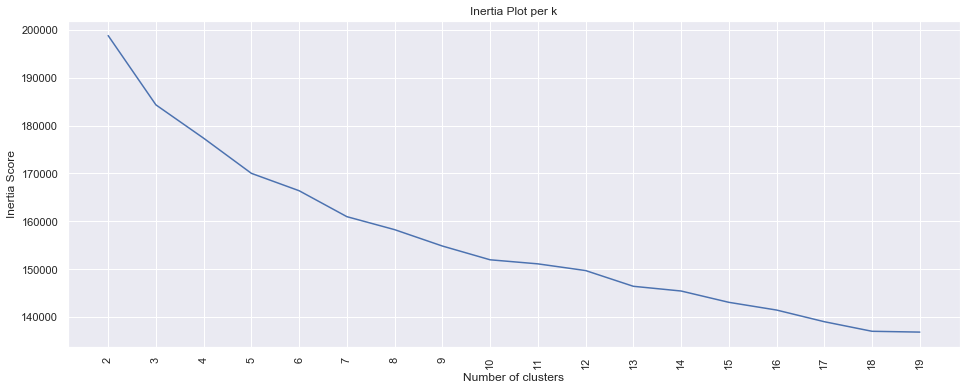

In [22]:
#let us now plot the inertia on graph.(elbow method)
# Creating the screen plot for Intertia 
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

I am accepting 5 clusters as my optimal number of cluster- This is at point 3, this is a clear steep on my graph. It is the point where the graph starts to flat out- Also from a business point of view , it is better to have 5 distinct customer journey- instead of terget group of 6,7,8,9.

In [23]:
# Running K means on 5 clusters

kmeans = KMeans(n_clusters=5, random_state=2)
kmeans = kmeans.fit(X_train)




# "predictions" for new data
predictions = kmeans.predict(X_train)

# calculating the Counts of the cluster
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,5)

# Creating a datagrame
countframe = pd.DataFrame(counts, columns = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"])

# display
countframe

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,8240,10659,10051,10334,10716


###### summary on Test1, I see that the cluster have similar  amount of client. This could be because i used on the categorical variable for this test.  or because we do not have all the features in this test. So now i will include more of the features and test for kmeans and also see if the number of cluster is also adequate.


## Feature Engineering - Continuous and Categorical variable -Test 2

In [24]:
# Making categorical variables into numeric representation

#For this i am going to take out some features that not needed(or those i modified. this is to creat a good clean model)

feature = ['products','Address','Acquisition','businessTYPE','Yeargroup','Revenue_Value']

# keeping the columns we need - Drop the other columns for now, as we do not want them to impact our results (for now)
#newraw_data = raw_data[feature]
#print(raw_data.shape)

# Making categorical variables into numeric representation
raw_data1 = pd.get_dummies(raw_data, columns = feature)

# Notes:
# We can also do this with Label Encoding and OneHotEncoder from the preprocessing library

print(raw_data1.shape)
# print the shape

raw_data1.head()

(50000, 35)


,Client_ID,Years,intervals,purchase_date,prices,Revenue,products_1/2page,products_1/4page,products_3/4page,products_fullpage,...,businessTYPE_Resturant,businessTYPE_luxury_item,Yeargroup_0-6years,Yeargroup_15-22years,Yeargroup_7-14years,Yeargroup_above23years,Revenue_Value_high,Revenue_Value_low,Revenue_Value_medium,Revenue_Value_premium
0,1236805,26,1,11/7/2018 13:22,483.99,483.99,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
1,2836384,13,1,5/12/2018 11:29,353.99,353.99,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,5118289,28,3,5/31/2018 12:50,232.99,698.97,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,2497066,12,5,11/16/2018 15:58,232.99,1164.95,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4,2542664,5,7,12/6/2018 12:26,232.99,1630.93,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [26]:
raw_data1.drop(['Client_ID', 'purchase_date','prices'], axis=1, inplace=True) #Droping feature tha is not needed.

In [27]:
raw_data1

,Years,intervals,Revenue,products_1/2page,products_1/4page,products_3/4page,products_fullpage,Address_Backnang,Address_Böblingen,Address_Esslingen,...,businessTYPE_Resturant,businessTYPE_luxury_item,Yeargroup_0-6years,Yeargroup_15-22years,Yeargroup_7-14years,Yeargroup_above23years,Revenue_Value_high,Revenue_Value_low,Revenue_Value_medium,Revenue_Value_premium
0,26,1,483.99,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,13,1,353.99,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,28,3,698.97,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,12,5,1164.95,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4,5,7,1630.93,1,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,14,2,289.98,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
49996,30,4,931.96,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
49997,27,4,931.96,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
49998,11,1,144.99,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [28]:
#scale the data so that our kmeans accept the data as equal
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(raw_data1), columns=raw_data1.columns)

In [30]:
scaled_data

,Years,intervals,Revenue,products_1/2page,products_1/4page,products_3/4page,products_fullpage,Address_Backnang,Address_Böblingen,Address_Esslingen,...,businessTYPE_Resturant,businessTYPE_luxury_item,Yeargroup_0-6years,Yeargroup_15-22years,Yeargroup_7-14years,Yeargroup_above23years,Revenue_Value_high,Revenue_Value_low,Revenue_Value_medium,Revenue_Value_premium
0,1.173729,-0.616655,-0.408789,-0.786308,-0.369624,-0.432826,1.393385,2.009929,-0.499250,-0.502780,...,-0.355749,2.849986,-0.494149,-0.600299,-0.595091,1.614293,-0.372136,0.776813,-0.501593,-0.23817
1,-0.311321,-0.616655,-0.729245,-0.786308,-0.369624,2.310398,-0.717677,-0.497530,-0.499250,1.988943,...,-0.355749,-0.350879,-0.494149,-0.600299,1.680416,-0.619466,-0.372136,0.776813,-0.501593,-0.23817
2,1.402199,0.233212,0.121146,1.271766,-0.369624,-0.432826,-0.717677,-0.497530,-0.499250,1.988943,...,-0.355749,-0.350879,-0.494149,-0.600299,-0.595091,1.614293,-0.372136,-1.287312,1.993647,-0.23817
3,-0.425556,1.083080,1.269806,1.271766,-0.369624,-0.432826,-0.717677,-0.497530,-0.499250,-0.502780,...,-0.355749,2.849986,-0.494149,-0.600299,1.680416,-0.619466,2.687188,-1.287312,-0.501593,-0.23817
4,-1.225199,1.932947,2.418467,1.271766,-0.369624,-0.432826,-0.717677,-0.497530,2.003005,-0.502780,...,2.810969,-0.350879,2.023680,-0.600299,-0.595091,-0.619466,-0.372136,-1.287312,-0.501593,4.19868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.197087,-0.191722,-0.887032,-0.786308,2.705451,-0.432826,-0.717677,-0.497530,2.003005,-0.502780,...,-0.355749,-0.350879,-0.494149,-0.600299,1.680416,-0.619466,-0.372136,0.776813,-0.501593,-0.23817
49996,1.630668,0.658146,0.695476,1.271766,-0.369624,-0.432826,-0.717677,-0.497530,-0.499250,-0.502780,...,-0.355749,-0.350879,-0.494149,-0.600299,-0.595091,1.614293,-0.372136,-1.287312,1.993647,-0.23817
49997,1.287964,0.658146,0.695476,1.271766,-0.369624,-0.432826,-0.717677,-0.497530,-0.499250,-0.502780,...,-0.355749,-0.350879,-0.494149,-0.600299,-0.595091,1.614293,-0.372136,-1.287312,1.993647,-0.23817
49998,-0.539791,-0.616655,-1.244439,-0.786308,2.705451,-0.432826,-0.717677,-0.497530,-0.499250,-0.502780,...,-0.355749,-0.350879,-0.494149,-0.600299,1.680416,-0.619466,-0.372136,0.776813,-0.501593,-0.23817


In [31]:
Z_train = scaled_data.values

### Kmeans for this set of data Test 2.

In [32]:
# How to find the best number of clusters?

# Running K means with multible cluster(20 here)

no_of_clusters = range(2,20) #[2,3,4,5,6,7,8,9-19]
inertia = []


for c in no_of_clusters:
    kmeans = KMeans(n_clusters=c, random_state=2)
    kmeans = kmeans.fit(Z_train)
    j = kmeans.inertia_
    inertia.append(j)
    print("The inertia for :", c, "Clusters is:", j)

The inertia for : 2 Clusters is: 1445824.286656853
The inertia for : 3 Clusters is: 1363203.1587226458
The inertia for : 4 Clusters is: 1298441.5727214809
The inertia for : 5 Clusters is: 1251843.0909076498
The inertia for : 6 Clusters is: 1194645.320480039
The inertia for : 7 Clusters is: 1169137.9897178528
The inertia for : 8 Clusters is: 1128705.3000825965
The inertia for : 9 Clusters is: 1110260.5760909484
The inertia for : 10 Clusters is: 1086106.7162056568
The inertia for : 11 Clusters is: 1050736.3691246328
The inertia for : 12 Clusters is: 1020177.3977467057
The inertia for : 13 Clusters is: 1018924.207927245
The inertia for : 14 Clusters is: 992139.2239547209
The inertia for : 15 Clusters is: 979758.889704568
The inertia for : 16 Clusters is: 963910.5279140383
The inertia for : 17 Clusters is: 956713.3134833715
The inertia for : 18 Clusters is: 945137.6034171941
The inertia for : 19 Clusters is: 939316.5661068615


Text(0.5, 1.0, 'Inertia Plot per k')

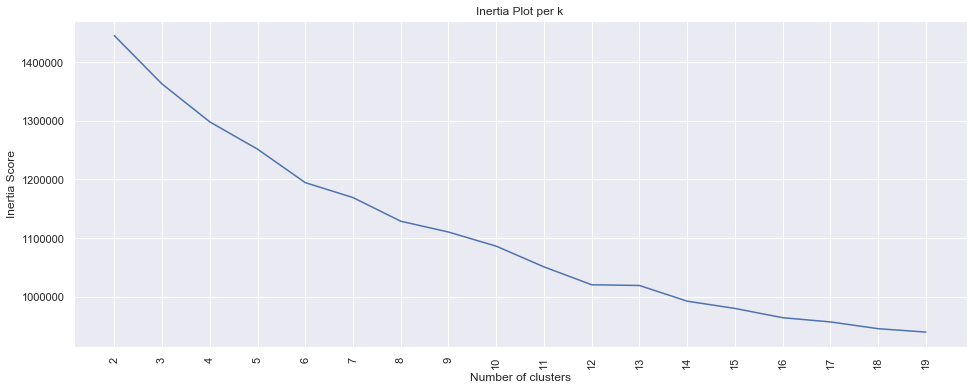

In [39]:
#let us now plot the inertia on graph.(elbow method)
# Creating the screen plot for Intertia 
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

##### Fisrt look , i see at point after 4 , the 1st major decline on my inertia score.  With this i  go for 4 kmeans clustering on the test 2 data  

In [34]:
# Running K means on 4 clusters

kmeans = KMeans(n_clusters=4, random_state=2)
kmeans = kmeans.fit(Z_train)




# "predictions" for new data
predictions1 = kmeans.predict(Z_train)

# calculating the Counts of the cluster
unique1, counts1 = np.unique(predictions1, return_counts=True)
counts1 = counts1.reshape(1,4)

# Creating a datagrame
countframe1 = pd.DataFrame(counts1, columns = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4"])

# display
countframe1

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,14251,16932,8766,10051


###### summary on Test2, Now with additional features the clusters have a better distribution of client.  I will now use data in test for further analysis.  Using PCA, I will try and improve my kmeans clustering and visualise the clusters

# Principal Component Analysis (PCA) to Visualize & improve results

- What is it?
PCA is a dimensionality reduction technique that transforms a number of possibly correlated variables into a smaller number of uncorrelated variables; called principal components
The goal of PCA is to extract the most important information from the data table by compressing the size of the data set and keeping only the important information; then PCA computes new variables called principal components.

Explained variance ratio (first two components): [0.114032 0.071529]


<Figure size 432x288 with 0 Axes>

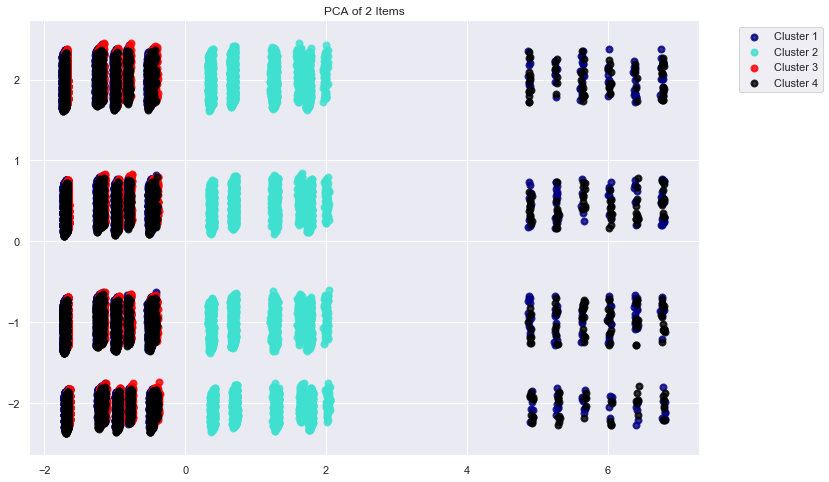

In [35]:
# Running PCA to Visualize the data

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Z = Z_train
y_num = predictions

target_names = ["Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

pca = PCA(n_components=2, random_state = 453)
Z_r = pca.fit(Z).transform(Z)


# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [ 1, 2, 3, 4], target_names):
    plt.scatter(Z_r[y_num == i, 0], Z_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

##### with 2 principal conponent(remeber we have 32 component/columns . This what our clusters look like.  but it only  about 18% of the data set.

##### Why dimensionality reduction could help k-means perform better:

- Kmeans is extremely sensitive to scale, and when you have a lot of attributes there is no true scale anymore. This is where PCA comes in since it whitens your data.
- By doing this, you will remove global correlation which can sometimes give better results. K-means is a "least squares" optimization problem; same with PCA.
- Kmeans tries to find the least squares partition of the data while PCA finds the least squares cluster membership vector. The first eigenvector has the largest variance (smallest inertia), hence splitting on this vector (which shows the cluster membership - not input data coordinates) means maximization of cluster variance; better fit for Kmeans.
- By maximizing between cluster variance, you minimize within-cluster variance. Therefore, applying PCA before clustering could potentially help you get better clusters (with more variance) in Kmeans.
- 95% explained variance should be the criterium when choosing the number of principal components

## Identifying the "best" number of components

In [40]:
# Trying with Dimentionality reduction and then Kmeans

n_components = Z.shape[1]

# Running PCA with all components
pca = PCA(n_components=n_components, random_state = 453)
zZ_r = pca.fit(Z).transform(Z)


# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_95 = total_variance * 0.95
print("The 95% variance we want to have is: ", var_95)
print("")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
print("Variance explain with 10 n_components: ", sum(a["Explained Variance"][0:10]))
print("Variance explain with 15 n_components: ", sum(a["Explained Variance"][0:15]))
print("Variance explain with 20 n_components: ", sum(a["Explained Variance"][0:20]))
print("Variance explain with 21 n_components: ", sum(a["Explained Variance"][0:21]))
print("Variance explain with 24 n_components: ", sum(a["Explained Variance"][0:24]))
print("Variance explain with 27 n_components: ", sum(a["Explained Variance"][0:27]))
print("Variance explain with 30 n_components: ", sum(a["Explained Variance"][0:30]))









Total Variance in our dataset is:  32.000640012800275
The 95% variance we want to have is:  30.40060801216026

Variance explain with 10 n_components:  17.175172332583642
Variance explain with 15 n_components:  23.110445932273777
Variance explain with 20 n_components:  28.725351252149164
Variance explain with 21 n_components:  29.842425084913852
Variance explain with 24 n_components:  31.951372379533563
Variance explain with 27 n_components:  32.000640012800275
Variance explain with 30 n_components:  32.000640012800275


##### Our 95% variance is 30.4 and we achieved that with 21 components

The innertia for : 2 Clusters is: 1339399.3294817023
The innertia for : 3 Clusters is: 1265069.8259943158
The innertia for : 4 Clusters is: 1200323.3869372506
The innertia for : 5 Clusters is: 1151055.6601621914
The innertia for : 6 Clusters is: 1110230.5205196852
The innertia for : 7 Clusters is: 1093750.8535512888
The innertia for : 8 Clusters is: 1064632.6587220258
The innertia for : 9 Clusters is: 1038440.6440439784
The innertia for : 10 Clusters is: 1021829.3392283962
The innertia for : 11 Clusters is: 998571.3903637562
The innertia for : 12 Clusters is: 970131.945760297
The innertia for : 13 Clusters is: 948769.7568625798
The innertia for : 14 Clusters is: 933650.8148173776
The innertia for : 15 Clusters is: 928192.6411399064
The innertia for : 16 Clusters is: 912622.4909203978
The innertia for : 17 Clusters is: 906373.2138148173
The innertia for : 18 Clusters is: 898495.7822078521
The innertia for : 19 Clusters is: 886906.2826640807


Text(0.5, 1.0, 'Inertia Plot per k')

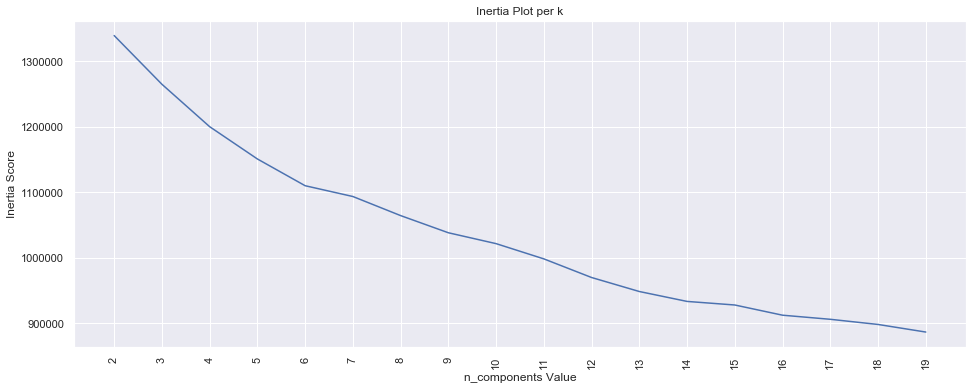

In [41]:
# Running PCA again with 21 components and also rerun kmeans to see if there is an improvement
pca = PCA(n_components=21, random_state = 453)
Z_r = pca.fit(Z).transform(Z)

inertia = []

#running Kmeans

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(Z_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)

# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

##### Conclusion:
We managed to improve our results by reducing inertia.  Give me confidence that 4 cluster is adequate- the graph shows more clearly  from 4 to 5 , there is more steep. 

Explained variance ratio (21 components): [0.114032 0.071542 0.051192 0.046982 0.046867 0.044068 0.042682 0.041057
 0.039175 0.039117 0.039093 0.038966 0.036665 0.035584 0.035165 0.035148
 0.035140 0.035090 0.035074 0.035010 0.034908]


<Figure size 432x288 with 0 Axes>

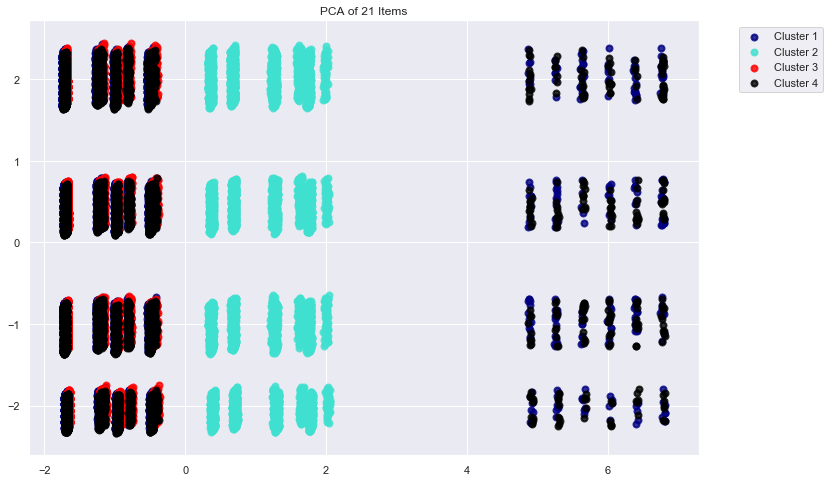

In [42]:
# Running PCA to Visualize the data aga



Z = Z_train
y_num = predictions

target_names = ["Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

pca = PCA(n_components=21, random_state = 453)
Z_r = pca.fit(Z).transform(Z)


# Percentage of variance explained for each components
print('Explained variance ratio (21 components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [ 1, 2, 3, 4], target_names):
    plt.scatter(Z_r[y_num == i, 0], Z_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 21 Items')
plt.show()

##### VISUAL FROM GRAPH ARE SIMILAR AND SO I HAVE OPTIMIZED ENOUGH

## Running Kmeans with 4 clusters and using a PCA dataset with 21 components

In [50]:
# Running PCA with 21 PC
pca = PCA(n_components=21, random_state = 453)
Z_r = pca.fit(Z).transform(Z)

# Running Kmeans with 4 Ks
kmeans = KMeans(n_clusters=4, random_state=2)
kmeans = kmeans.fit(Z_r)

clusters = kmeans.labels_

# Attachine the clusters back to our initial Dataset that has all the data
raw_data['Clusters'] = clusters

# Creating a cluster Category
raw_data['Clusters Category'] = 'No Data'
raw_data['Clusters Category'].loc[raw_data['Clusters'] == 0] = 'Cluster 1'
raw_data['Clusters Category'].loc[raw_data['Clusters'] == 1] = 'Cluster 2'
raw_data['Clusters Category'].loc[raw_data['Clusters'] == 2] = 'Cluster 3'
raw_data['Clusters Category'].loc[raw_data['Clusters'] == 3] = 'Cluster 4'


raw_data.head(5)

C:\Users\chris\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Client_ID,Years,intervals,purchase_date,prices,products,Address,Acquisition,businessTYPE,Revenue,Yeargroup,Revenue_Value,Clusters,Clusters Category
0,1236805,26,1,11/7/2018 13:22,483.99,fullpage,Backnang,reffered,luxury_item,483.99,above23years,low,2,Cluster 3
1,2836384,13,1,5/12/2018 11:29,353.99,3/4page,Esslingen,campaigns,Hotel,353.99,7-14years,low,0,Cluster 1
2,5118289,28,3,5/31/2018 12:50,232.99,1/2page,Esslingen,reffered,Book_Store,698.97,above23years,medium,1,Cluster 2
3,2497066,12,5,11/16/2018 15:58,232.99,1/2page,Stuttgart,reffered,luxury_item,1164.95,7-14years,high,3,Cluster 4
4,2542664,5,7,12/6/2018 12:26,232.99,1/2page,Böblingen,campaigns,Resturant,1630.93,0-6years,premium,3,Cluster 4


# Prepare data into CSV for Power BI dashboard

In [53]:
# Exporting the data in a CSV

raw_data.to_csv('B2B_Cluster_Output.csv', sep='\t')

##### Let us go over to my power BI desktop for reporting.